In [274]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.io import wavfile

samplerate, data = wavfile.read('hjem fra fabrikken.wav') # 120 BPM
# samplerate, data = wavfile.read('FISHER - Losing It (Official Audio).wav') # 125 BPM
# samplerate, data = wavfile.read('Benjamin Hav - Hurra ft. PIND, Emil Kruse.wav')
# samplerate, data = wavfile.read('Tobias Rahim & Andreas Odbjerg - STOR MAND.wav') # 146 BPM

assert(data.shape[-1] == 2)

data = data.mean(axis=-1)

data = data / np.max(np.abs(data))

noise_amount = 0.5
data += noise_amount * np.random.uniform(low=-1, high=1, size=data.shape)
noise_floor = noise_amount / 4


# new_samplerate = 700
# new_samplerate = 1000
# new_samplerate = 4000
# new_samplerate = 1000
# new_samplerate = 1024
new_samplerate = 512
resample_pos = np.linspace(0, len(data), int(len(data) * new_samplerate / samplerate))
# print(resample_pos.shape)
# print(data.shape)
# new_data = scipy.interpolate.interp1d(, data)
new_data = np.interp(resample_pos, np.arange(0, len(data)), data)
# print(len(new_data))

samplerate = new_samplerate
data = new_data


print(np.min(data), np.max(data))
data

-1.3542197323239702 1.3945433884053875


array([ 0.16389414, -0.30539932,  0.18627906, ...,  0.38667095,
       -0.37085226,  0.34325804])

Text(0, 0.5, 'DC offset')

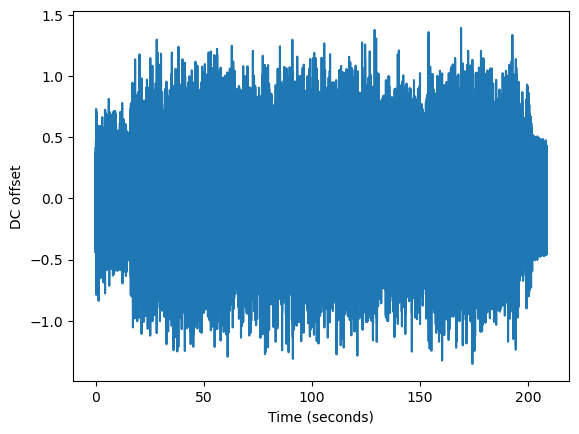

In [275]:
time = np.arange(len(data)) / samplerate
plt.plot(time, data)
plt.xlabel('Time (seconds)')
plt.ylabel('DC offset')

Text(0, 0.5, 'DC offset')

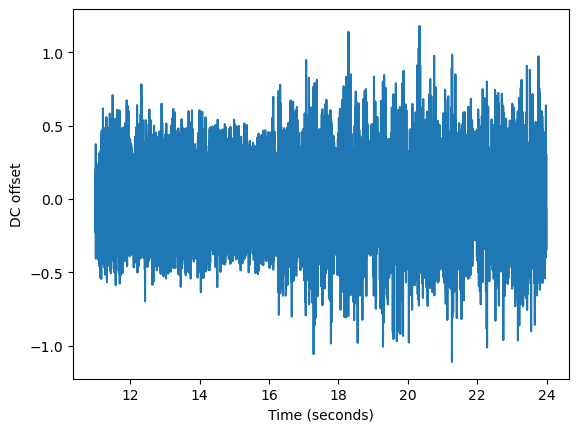

In [276]:
section_start = samplerate * 11
# section_end = samplerate * 18
section_end = samplerate * 24

section_time = time[section_start:section_end]
section_data = data[section_start:section_end]

plt.plot(section_time, section_data)
plt.xlabel('Time (seconds)')
plt.ylabel('DC offset')

Text(0, 0.5, 'Brightness')

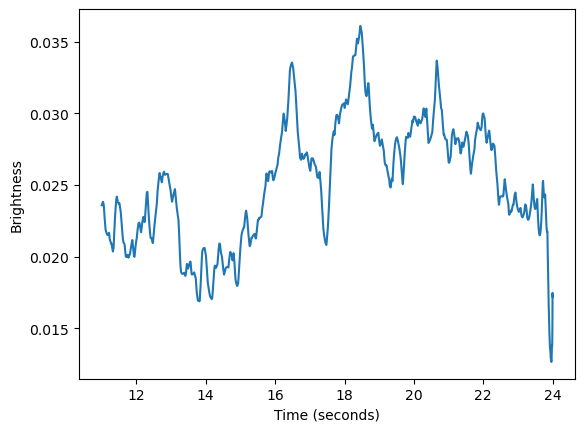

In [277]:
from scipy import signal


def process(input, peak_decay=0.001, norm_decay = 0.1):
    sos = signal.butter(1, 5, 'low', fs=samplerate, output='sos')
    filtered = signal.sosfilt(sos, section_data)
    
    peak_decay = peak_decay ** (1 / samplerate)
    norm_decay = norm_decay ** (1 / samplerate)
    
    output = np.copy(input)
    filter_peak = 0
    full_peak = 0

    min_peak = 0
    max_peak = 0

    # norm = 0

    slow_peak = 0

    # rms = 0.001
    for i in range(len(filtered)):
        # rms = np.sqrt((1 - rms_decay) * (input[i] ** 2) + rms_decay * (rms ** 2))
        # output[i] = np.max(arr[i-k:i])
        # full_peak = max(peak_decay * full_peak, abs(input[i]))
        filter_peak = max(peak_decay * filter_peak, abs(filtered[i]))
        slow_peak = max(norm_decay * slow_peak, abs(filtered[i]))


        # norm = max(norm_decay * norm, full_peak)
        # output[i] = filter_peak / norm
        output[i] = (filter_peak - 0.5 * slow_peak)

    for i in range(len(output)):
        output[i] = np.mean(output[i:i+500])
    # return output / rms
    return np.clip(output, a_min=0, a_max=None)

plt.plot(section_time, process(section_data))
plt.xlabel('Time (seconds)')
plt.ylabel('Brightness')

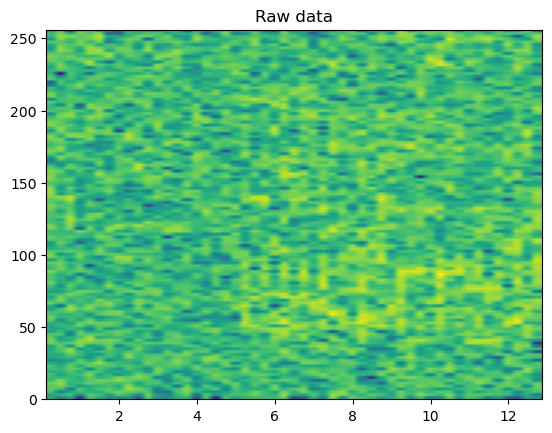

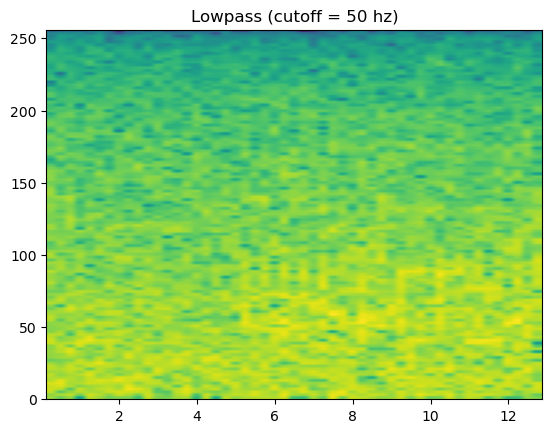

In [278]:
# plt.specgram(section_data, Fs=samplerate, NFFT=2048, noverlap=512)
def plot_spectrogram(data):
    plt.figure()
    plt.title('Raw data')
    plt.specgram(data, Fs=samplerate)
    plt.plot()

    freq = 50
    # sos = signal.butter(1, 5, 'low', fs=samplerate, output='sos')
    sos = signal.butter(1, freq, 'low', fs=samplerate, output='sos')
    filtered = signal.sosfilt(sos, data)

    plt.figure()
    plt.title(f'Lowpass (cutoff = {freq} hz)')
    plt.specgram(filtered, Fs=samplerate)
    plt.plot()
    
plot_spectrogram(section_data)
    

In [279]:
# def bandpass(input, order, low_cutoff, high_cutoff):
#     sos_low = signal.butter(order, low_cutoff, 'low', fs=samplerate, output='sos')
#     sos_high = signal.butter(order, high_cutoff, 'high', fs=samplerate, output='sos')
#     return signal.sosfilt(sos_low, signal.sosfilt(sos_high, input))
#     
# def peak(input, falloff_per_sec=0.1):
#     falloff_per_sample = falloff_per_sec ** (1 / samplerate)
#     peak = 0
#     output = np.zeros_like(input)
#     for i in range(len(input)):
#         peak = max(input[i], falloff_per_sample * peak)
#         output[i] = peak
#     return output
# 
# def transient(input):
#     # n_bands = 4
#     # min_band = 20
#     # max_band = 10000
#     # order = 4
# 
#     # n_bands = 8
#     # min_band = 1
#     # max_band = 4000
#     # min_weight = 1
#     # # max_weight = 0.5
#     # max_weight = 0.3
#     # order = 4
# 
#     n_bands = 4
#     min_band = 1
#     # max_band = 400
#     max_band = 499
#     min_weight = 1
#     # max_weight = 0.5
#     max_weight = 0.9
#     order = 3
#     
#     band_exp = (max_band / min_band) ** (1 / (n_bands))
#     weight_exp = (max_weight / min_weight) ** (1 / (n_bands))
# 
#     band_freqs = [round(min_band * band_exp ** i) for i in range(n_bands + 1)]
#     band_weights = np.array([min_weight * weight_exp ** i for i in range(n_bands)])
# 
#     print(f'band freqs: {band_freqs}')
#     # bands = [bandpass(input, order, band_freqs[i], band_freqs[i + 1]) for i in range(n_bands)]
#     bands = [band_weights[i] * bandpass(input, order, band_freqs[i], band_freqs[i + 1]) for i in range(n_bands)]
#     bands_peaks = [peak(band) for band in bands]
#     
#     times = np.arange(len(input)) / samplerate
#     
#     plt.figure()
#     for band in bands_peaks:
#         plt.plot(times, band)
# 
#     plt.figure()
#     plt.plot(times, np.sum(np.array(bands_peaks) ** 2, axis=0))
#     
#     slow_peak = np.array([peak(band, falloff_per_sec=0.5) for band in bands])
#     fast_peak = np.array([peak(band, falloff_per_sec=0.1) for band in bands])
# 
#     plt.figure()
#     plt.plot(times, np.sum((slow_peak - fast_peak) ** 2, axis=0))
# 
#     slow_const = 0.7
#     peak_diff = np.clip(np.sum(fast_peak ** 2, axis=0) - slow_const * np.sum(slow_peak ** 2, axis=0), a_min=0, a_max=None)
#     plt.figure()
#     plt.plot(times, peak_diff)
#     
#     plt.figure()
#     plt.plot(times, peak(peak_diff, 0.03))
# 
#     plt.figure()
#     plt.plot(times, peak(peak_diff, 0.03) / peak(peak_diff, 0.8))
# 
# 
# 
#     # std = np.std(bands, axis=0)
#     # plt.plot(section_time, np.clip(1 / std, a_max=250, a_min=None))
# 
# 
#     # plt.figure()
#     # for band in bands:
#     #     plt.plot(section_time, band)
#     
# 
# 
# transient(section_data)

In [280]:
# def lowpass(input, order, cutoff):
#     sos = signal.butter(order, cutoff, 'low', fs=samplerate, output='sos')
#     return signal.sosfilt(sos, input)
# 
# def transient_fast(input):
#     n_bands = 4
#     min_band = 1
#     max_band = 499
#     order = 2
# 
#     band_exp = (max_band / min_band) ** (1 / (n_bands))
#     # band_freqs = [round(min_band * band_exp ** i) for i in range(n_bands + 1)]
#     band_freqs = [min_band * band_exp ** i for i in range(n_bands + 1)]
#     lowpasses = [lowpass(input, order, band_freqs[i]) for i in range(n_bands + 1)]
#     bands = [lowpasses[i + 1] - lowpasses[i] for i in range(n_bands)]
# 
#     slow_peak = np.array([peak(band, falloff_per_sec=0.5) for band in bands])
#     fast_peak = np.array([peak(band, falloff_per_sec=0.1) for band in bands])
#     
#     threshold = 0.8
#     transient = np.sum(fast_peak ** 2, axis=0) - threshold * np.sum(slow_peak ** 2, axis=0)
#     transient = np.clip(transient, a_min=0.0, a_max=None)
#     # transient = np.sqrt(np.clip(transient, a_min=0.0, a_max=None))
#     
#     times = np.arange(len(input)) / samplerate
#     plt.figure()
#     plt.title('Transients (raw)')
#     plt.plot(times, transient)
# 
#     plt.figure()
#     plt.title('Transients (smoothed)')
#     plt.plot(times, peak(transient, 0.03))
# 
#     plt.figure()
#     plt.title('Transients (smoothed + normalized)')
#     epsilon = 0.001
#     plt.plot(times, peak(transient, 0.03) / (epsilon + peak(transient, 0.8)))
#     
# transient_fast(section_data)

input size: 2048
confidence: 0.045240955283563034
bpm: 120.0


/tmp/ipykernel_5743/1465780479.py:105: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output[i] = normalized


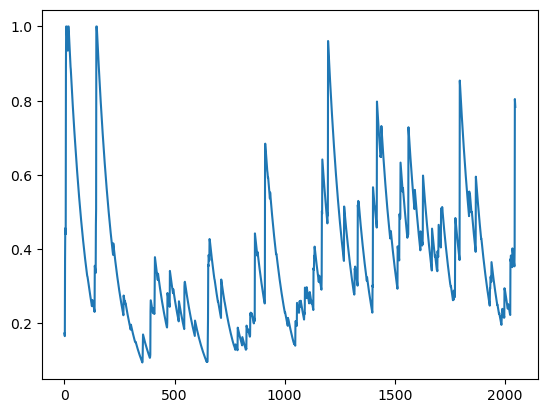

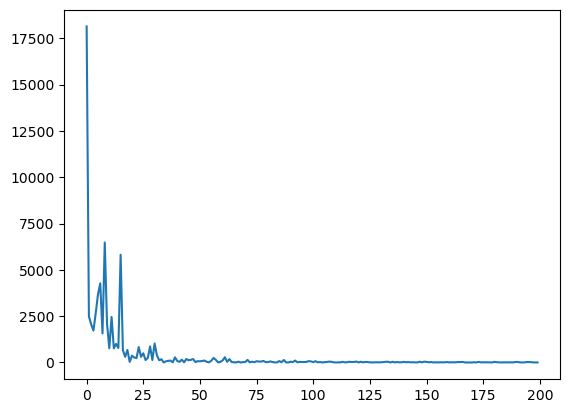

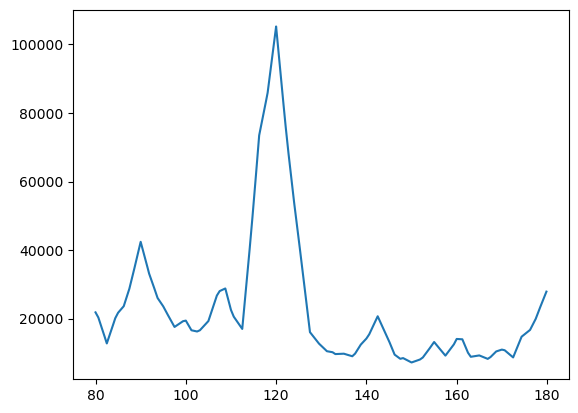

In [281]:
# 2nd order butterworth lowpass filter
class BWLowpass:
    def __init__(self, cutoff, samplerate):
        # Calculate coefficients
        K = np.tan(np.pi * cutoff / samplerate)
        K2 = K * K
        
        sqrt2 = np.sqrt(2)

        self.b0 = K2 / (1 + sqrt2 * K + K2)
        # self.b1 = 2 * self.b0
        # self.b2 = self.b0
        self.a1 = 2 * (K2 - 1) / (1 + sqrt2 * K + K2)
        self.a2 = (1 - sqrt2 * K + K2) / (1 + sqrt2 * K + K2)
        
        # Initialize state buffer
        self.x1 = 0.0
        self.x2 = 0.0
        self.y1 = 0.0
        self.y2 = 0.0
        
    def next(self, sample):
        x0 = sample
        x1 = self.x1
        x2 = self.x2
        y1 = self.y1
        y2 = self.y2

        # Calculate output sample y0
        # y0 = self.b0 * x0
        # y0 += self.b1 * x1
        # y0 += self.b2 * x2
        y0 = self.b0 * (x0 + 2 * x1 + x2)
        # y0 += self.b1 * x1
        y0 -= self.a1 * y1
        y0 -= self.a2 * y2
        
        # Shift state buffer
        self.x2 = x1
        self.x1 = x0
        
        self.y2 = y1
        self.y1 = y0
        
        return y0

class BandPeaks():
    def __init__(self, num_bands, falloff, samplerate):
        self.decay = falloff ** (1 / samplerate)
        self.num_bands = num_bands
        self.peak = np.zeros(num_bands)
    
    def next(self, samples):
        self.peak = np.maximum(np.abs(samples), self.decay * self.peak)
        return self.peak

def transient_realtime(input):
    # Initialization
    n_bands = 3
    # min_band = 1
    min_band = 20
    # max_band = 499
    max_band = 255
    # max_band = 127
    # threshold = 0.8
    # threshold = 0.5
    threshold = 0.0

    band_exp = (max_band / min_band) ** (1 / (n_bands))
    band_freqs = [min_band * band_exp ** i for i in range(n_bands + 1)]
    lowpasses = [BWLowpass(band_freqs[i], samplerate) for i in range(n_bands + 1)]
    
    # bandpeaks_fast = BandPeaks(n_bands, 0.1, samplerate)
    bandpeaks_fast = BandPeaks(n_bands, 0.05, samplerate)
    bandpeaks_slow = BandPeaks(n_bands, 0.5, samplerate)

    peak_smoothing = BandPeaks(1, 0.03, samplerate)
    peak_normalization = BandPeaks(1, 0.8, samplerate)

    # epsilon = 0.0001
    # peak_smoothing.next(epsilon)
    bandpeaks_fast.next(noise_floor)
    peak_normalization.next(noise_floor)
    
    output = np.zeros_like(input)

    # Main loop
    for i in range(len(input)):
        sample = input[i]

        lps = [lp.next(sample) for lp in lowpasses]
        bands = [lps[i + 1] - lps[i] for i in range(n_bands)]

        fast_peak = np.clip(bandpeaks_fast.next(bands) - noise_floor, a_min=0, a_max=None)
        # fast_peak = bandpeaks_fast.next(bands) - noise_floor/4, a_min=0, a_max=None)
        # output[i] = np.sum(fast_peak ** 2)
        slow_peak = bandpeaks_slow.next(bands)
        
        # transient = np.sum(fast_peak ** 2) - threshold * np.sum(slow_peak ** 2)
        # transient = np.clip(transient, a_min=0.0, a_max=None)
        transient = np.sum(fast_peak ** 2)
        # smoothed = peak_smoothing.next(transient)
        normalized = transient / (peak_normalization.next(transient))
        # normalized = smoothed / (peak_normalization.next(transient))
        output[i] = normalized
        # output[i] = smoothed
        # output[i] = transient

    # output = output[:8*samplerate]
    # output = input
    
    plt.plot(output)
    
    fft = np.fft.fft(output)
    print(f'input size: {len(input)}')
    magnitudes = np.abs(fft)[1:] ** 2

    plt.figure()
    plt.plot(magnitudes[0:200])

    # test = np.sum(magnitudes * np.arange(1, len(magnitudes) + 1)) / np.sum(magnitudes)
    # print(test)

    # print(len(magnitudes) / samplerate)
    # plt.plot(magnitudes[1:100])
    # print(np.argmax(magnitudes[1:]) * samplerate / len(output) * 60)
    # print(180 / 60 * len(output) / samplerate)

    # print(80 / 60 * len(output) / samplerate)
    min_idx = 80 / 60 * (2 * len(fft)) / samplerate
    max_idx = 180 / 60 * (2 * len(fft)) / samplerate
    # points = np.linspace(min_idx, max_idx, 50000)
    
    bpm_step = 1/8
    bpms = np.arange(80, 180, step=bpm_step)
    points = bpms / 60 * (2 * len(fft)) / samplerate
    
    # points = np.linspace(min_idx, max_idx, 8192)
    indices = np.arange(1, len(magnitudes) + 1)
    max_sum = -np.inf
    max_point = None
    sums = np.zeros_like(points)
    total = 0
    for i in range(len(points)):
        point = points[i]
        sum = 0
        # for mult in range(1, 8):
        #     # sum += np.log(np.interp(mult * point, indices, magnitudes))
        #     sum += 1/mult * np.interp(mult * point, indices, magnitudes)
        for mult in range(1, 5):
            # sum += np.log(np.interp(mult * point, indices, magnitudes))
            sum += point * np.interp(mult * point, indices, magnitudes)

        sums[i] = sum
        total += sum

        if sum >= max_sum:
            max_sum = sum
            max_point = point
            
    print(f'confidence: {max_sum / (total * bpm_step)}')

    # print(f'max_point')
    plt.figure()
    plt.plot(points * samplerate / (2 * len(fft)) * 60, sums)

    print(f'bpm: {max_point * samplerate / (2 * len(fft)) * 60}')

    # times = np.arange(len(input)) / samplerate
    # plt.plot(times, output)

# transient_realtime(data[:samplerate*176][-(samplerate * 4):])        
# transient_realtime(data[:samplerate*140][-(samplerate * 8):])        
transient_realtime(data[:samplerate*45][-(samplerate * 4):])        